In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from lenstronomy.LightModel.Profiles.interpolation import Interpol
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util.param_util import phi_q2_ellipticity,ellipticity2phi_q
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util.analysis_util import half_light_radius
import scipy.optimize as opt
from scipy.stats import norm, uniform, truncnorm
import glob, tqdm
import pandas as pd

In [34]:
size=".5-1.5"
# size=".15-.5"
# size=".02-.15"

home = "/global/cfs/projectdirs/deepsrch/jwst_sims/data/"
#Path to VELA download
vela_path = '/global/cfs/projectdirs/deepsrch/vela'

In [35]:
#Loads CosmoDC2 catalog
import GCRCatalogs
cat = GCRCatalogs.load_catalog("desc_cosmodc2")
keys = ['redshift', 'halo_mass', 'stellar_mass', 'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'is_central']
dc2 = cat.get_quantities(keys)

#size limits to help with speed and theta_E distributions
if size=='.5-1.5':
    inds = dc2['is_central']*(dc2['halo_mass']>1e13)
elif size=='.15-.5':
    inds = dc2['is_central']*(dc2['halo_mass']>5e12)*(dc2['halo_mass']<5e13)
elif size=='.02-.15':
    inds = dc2['is_central']*(dc2['halo_mass']>1e10)*(dc2['halo_mass']<5e12)

ms = cat.get_quantities('stellar_mass')['stellar_mass']
for key in keys:
    dc2[key] = dc2[key][inds]
zinds = np.arange(len(dc2['redshift']))
np.random.shuffle(zinds)

zs_dc2 = dc2['redshift']

#Masses created using lens_forecast.ipynb
ms_dict = np.load(home+'zahid_ms.npz')
#Decreases mass range for .15-.5
if size==".15-.5":
    size=".05-.5"
sizes = np.array(ms_dict.files)
low, up = np.array([float(_) for _ in size.split('-')])
sizes_f = [float(_) for _ in sizes]
sizes = sizes[(sizes_f>=low)*(sizes_f<up)]
if size==".05-.5":
    size=".15-.5"

In [36]:
def stellar_mass(M, z):
    mM10 = 11.88
    mu = 0.019
    mM00 = 0.0282
    nu = -0.72
    gamma0 = 0.556
    gamma1 = -0.26
    beta0 = 1.06
    beta1 = 0.17
    
    M1=10**(11.88*(z+1)**mu)
    mM0=mM00*(z+1)**nu
    gamma = gamma0*(z+1)**gamma1
    beta = beta1*z+beta0
    shmr = 2*mM0/((M/M1)**(-beta)+(M/M1)**gamma)
    return shmr * M

def mHalo(m, z):
    if z<.5:
        M1 = 10**12.629
        M0 = 10**10.855
        beta=0.487
        delta=0.935
        gamma=1.939
    elif z<.8:
        M1 = 10**12.793
        M0 = 10**10.927
        beta=0.502
        delta=0.802
        gamma=3.132    
    elif z < 1.1:
        M1 = 10**12.730
        M0 = 10**11.013
        beta=0.454
        delta=1.109
        gamma=1.925    
    elif z < 1.5:
        M1 = 10**12.673
        M0 = 10**10.967
        beta=0.393
        delta=0.746
        gamma=0.335    
    elif z < 2.0:
        M1 = 10**12.787
        M0 = 10**11.040
        beta=0.410
        delta=0.716
        gamma=1.312   
    elif z < 2.5:
        M1 = 10**13.097
        M0 = 10**11.254
        beta=0.495
        delta=0.668
        gamma=1.077    
    elif z < 3.0:
        M1 = 10**12.627
        M0 = 10**10.920
        beta=0.393
        delta=0.274
        gamma=0.447   
    elif z < 3.5:
        M1 = 10**12.820
        M0 = 10**11.067
        beta=0.465
        delta=0.354
        gamma=0.741    
    elif z < 4.5:
        M1 = 10**13.638
        M0 = 10**12.222
        beta=0.551
        delta=1.557
        gamma=3.149    
    else:
        M1 = 10**13.547
        M0 = 10**12.105
        beta=0.567
        delta=1.427
        gamma=3.225    
                        
    Mhalo = 10**(np.log10(M1)+beta*np.log10(m/M0)+((m/M0)**delta)/(1+(m/M0)**(-gamma))-1/2)
    return Mhalo

#Loads VELA catalog
vela_cat = pd.read_csv(home+"JWST/hlsp_vela_multi_multi_vela_multi_v3_cat.txt", delim_whitespace=True)
vela_cat

,sim,z,scale,cam,mission,instrument,filter,flux_njy,abmag,mstar,mgas,mmet,sfr,mvir_dm,path
0,vela01,19.000000,0.05,cam00,hst,acs,f435w,0.000000e+00,NaN,2.713491e+05,8.672512e+10,5.582583e+02,0.317644,2.430748e+08,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
1,vela01,15.666667,0.06,cam00,hst,acs,f435w,1.916872e-32,110.693583,1.292812e+06,6.287650e+10,1.109931e+04,0.249550,5.074384e+08,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
2,vela01,13.285714,0.07,cam00,hst,acs,f435w,8.964136e-27,96.518795,2.304172e+06,5.971775e+10,2.083764e+04,0.975671,1.172963e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
3,vela01,11.500000,0.08,cam00,hst,acs,f435w,3.324756e-23,87.595666,6.421828e+06,4.147531e+10,6.125115e+04,1.051829,2.250957e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
4,vela01,10.111111,0.09,cam00,hst,acs,f435w,1.504973e-19,78.456244,1.317297e+07,3.853616e+10,1.457750e+05,2.183615,3.149162e+09,vela/vela01/cam00/hst/acs/f435w/hlsp_vela_hst_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807018,vela35,8.090909,0.11,cam18,wfirst,wfidrm15,z087,2.062675e-02,35.613989,2.376371e+08,4.918993e+10,2.291054e+06,14.120490,3.063316e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807019,vela35,7.333333,0.12,cam18,wfirst,wfidrm15,z087,2.558612e-01,32.880055,3.429454e+08,3.890345e+10,2.956734e+06,30.825400,4.156953e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807020,vela35,6.692308,0.13,cam18,wfirst,wfidrm15,z087,5.853500e+00,29.481526,6.192816e+08,3.175911e+10,4.611881e+06,27.574380,5.302207e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...
807021,vela35,6.142857,0.14,cam18,wfirst,wfidrm15,z087,2.230114e+01,28.029248,9.749514e+08,3.329994e+10,6.080173e+06,50.632260,6.498438e+10,vela/vela35/cam18/wfirst/wfidrm15/z087/hlsp_ve...


In [37]:
#Williams et al. (2018) JWST image and catalogs
with fits.open(home+'JWST/goods_s_F115W_2018_08_29.fits') as hdul:
    header = hdul[0].header
    sim = hdul[0].data * header['GAIN']
wcs = WCS(header)

with fits.open(home+'JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
    data_sf = hdul[1].data
with fits.open(home+'JWST/JADES_Q_mock_r1_v1.1.fits') as hdul:
    data_q = hdul[1].data

#limits of rectangle used:
#dec = [-27.83, -27.785]
#ra = [53.137, 53.222]

cut_sf= data_sf[data_sf['RA']>53.137]
cut_sf = cut_sf[cut_sf['RA']<53.222]
cut_sf = cut_sf[cut_sf['DEC']>-27.83]
cut_sf = cut_sf[cut_sf['DEC']<-27.785]
cut_q= data_q[data_q['RA']>53.137]
cut_q = cut_q[cut_q['RA']<53.222]
cut_q = cut_q[cut_q['DEC']>-27.83]
cut_q = cut_q[cut_q['DEC']<-27.785]

#scaling factor:
#1 unit of the simulations is 1/sum_to_flux=1/6.501853565914121=0.15380229497054293 nJy
sum_to_flux = 6.501853565914121
#Mass to Light ratio (calculated from Williams et al. (2018) catalog)
def ML_ratio(z):
    return 10**(2.15259223299506*np.log10(z)+6.61731435158865)

In [38]:
velas = glob.glob(vela_path+'/vela01/cam00/jwst/nircam/f115w/*')
velas.sort()
redshifts = np.zeros(len(velas))
for i in range(len(velas)):
    with fits.open(velas[i]) as hdul:
        vela_h = hdul[0].header
        vela_d = hdul[0].data
        redshifts[i] = vela_h['REDSHIFT']
#Chooses only the random cams
cams = np.array(["cam12", "cam13", "cam14", "cam15", "cam16", "cam17", "cam18"])
sims = glob.glob(vela_path+'/*')
sims = np.array([sim[-6:] for sim in sims])
redshifts

array([19.   , 15.667, 13.286, 11.5  , 10.111,  8.091,  7.333,  6.692,
        6.143,  5.667,  5.25 ,  4.882,  4.263,  4.   ,  3.762,  3.545,
        3.348,  3.167,  3.   ,  2.846,  2.704,  2.571,  2.448,  2.333,
        2.226,  2.125,  2.03 ,  1.941,  1.857,  1.778,  1.703,  1.632,
        1.564,  1.5  ,  1.439,  1.381,  1.326,  1.273,  1.222,  1.174,
        1.128,  1.083,  1.041,  1.   ])

In [39]:
#Kwargs setup
pixels = vela_d.shape[0]
pixel_size = vela_h['PIXSCALE']

background_rms = header['BKG']

lens_light_model_class = LightModel(['SERSIC_ELLIPSE'])
lens_model_class = LensModel(['SIE'], z_lens=1, z_source=6)

kwargs_lens = [{'theta_E':0, 'e1':0, 'e2':0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light = [{'amp':1, 'R_sersic': 1, 'n_sersic': 2, 'e1':0, 'e2':0, 'center_x': 0, 'center_y': 0}]

In [40]:
def sim_background(exp_time=10000, inds=range(len(cut_sf))):
    inds = inds
    pixels = 125
    exp_time = exp_time
    
    #lenstronomy setup
    bright = cut_sf[np.random.choice(inds)]
    kwargs_data = {'background_rms': background_rms, 'exposure_time': exp_time,
                   'ra_at_xy_0': -pixels/2*pixel_size, 'dec_at_xy_0': -pixels/2*pixel_size,
                   'transform_pix2angle':np.array([[pixel_size, 0.  ], [0.  , pixel_size]]), 
                   'image_data': np.zeros((pixels, pixels))}

    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    data_class = ImageData(**kwargs_data)

    #PSF
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.03, 'pixel_size': pixel_size, 'truncation': 3}
    psf_class = PSF(**kwargs_psf)

    kwargs_source = []

    #this section selects the galaxies in a cutout around a random galaxy
    #rad=radius of the cutout
    rad = pixels*pixel_size/2/3600
    #location of random central galaxy
    ra, dec = bright['RA'], bright['DEC']
    #gals = group of galaxies in cutout
    gals = cut_sf[cut_sf['RA']>ra-rad]
    gals = gals[gals['RA']<ra+rad]
    gals = gals[gals['DEC']>dec-rad]
    gals = gals[gals['DEC']<dec+rad]
    source_model_class1 = LightModel(['INTERPOL'])
    image_model1 = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
        source_model_class=source_model_class1, lens_light_model_class=lens_light_model_class,
        kwargs_numerics=kwargs_numerics)

    kwargs_lens[0]['theta_E'] = 0
    models = []
    
    #adds each environmental galaxy to the simulation
    for galind in range(len(gals)):
        center_x, center_y = norm.rvs(loc=0, scale=0.25, size=2)
        #uses a VELA object as the environmental source with 20% chance
        if np.random.random()>.8:
            #random VELA sim and cam
            sim = np.random.choice(sims)
            cam = np.random.choice(cams)

            #chooses closest redshift to the Williams+ galaxy
            redshifts = glob.glob(vela_path+'/'+sim+'/'+cam+'/jwst/nircam/f115w/*')
            redshifts = np.array([1/(int(r[107:110])/1000)-1 for r in redshifts])
            redshifts = np.sort(redshifts)[::-1]
            i = np.argmin(np.abs(redshifts-gals[galind]['redshift']))

            velas = glob.glob(vela_path+'/'+sim+'/'+cam+'/jwst/nircam/f115w/*')
            velas.sort()
            vela_d = fits.open(velas[i])[0].data
            #offset of galaxy in ra and dec from center
            dra, ddec = (gals[galind]['RA'] - ra)*3600, (gals[galind]['DEC'] - dec)*3600
            ks_temp = [{'image':vela_d, 'amp':1, 'scale':pixel_size, 'center_x':0, 'center_y':0}]
           
            #calculates total pixel sum of the galaxy to set the right amplitude
            flux = gals[galind]['NRC_F115W_fnu']
            query = vela_cat.query("sim=='"+sim+"' and cam=='"+cam+"' and z==%.8f and filter=='f115w'" % np.round(redshifts[i],8))
            if len(query)==0:
                return sim_background(exp_time=exp_time, inds=inds)
            vflux = query['flux_njy'].values[0]
            #calc_sum = desired pixel sum (flux) of the galaxy
            calc_sum = sum_to_flux * flux
            factor = norm.rvs(loc=0, scale=.7)
            #brightness increase to help neural network recognize bright environmental galaxies
            calc_sum *= 10**factor

            data_class = ImageData(**kwargs_data)
            source_model_class1 = LightModel(['INTERPOL'])
            image_model1 = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
                source_model_class=source_model_class1, lens_light_model_class=lens_light_model_class,
                kwargs_numerics=kwargs_numerics)
            image = image_model1.image(kwargs_lens, ks_temp, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                                       source_add=True, lens_light_add=False)
            
            pixs = np.arange(image.shape[0])
            #sersic radius of the VELA image
            re = half_light_radius(image, x_grid = pixs, y_grid = pixs, center_x=np.mean(pixs),center_y=np.mean(pixs))
            
            #rad_rat = ratio of the circularized radius of the Williams galaxy to the VELA galaxy
            rad_rat = np.sqrt(gals[galind]['Re_maj']**2*gals[galind]['axis_ratio'])/(re*pixel_size)
            #scales image up/down to roughly match the right angular size
            ks_temp[0]['scale'] = ks_temp[0]['scale']*rad_rat
            image = image_model1.image(kwargs_lens, ks_temp, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                source_add=True, lens_light_add=False)
            
            #sets x and y from dra, ddec offsets foudn before
            ks_temp[0]['center_x']=center_x-dra
            ks_temp[0]['center_y']=center_y+ddec
            #rare bug caused no flux: just re-generates in that case
            if np.sum(image)==0:
                return sim_background(exp_time=exp_time, inds=inds)
            #scales amplitude to set the proper total pixel sum of the galaxy
            ks_temp[0]['amp'] = calc_sum/np.sum(image)
            
            #appends the kwargs and model to the full source model
            kwargs_source.append(ks_temp[0])
            models.append('INTERPOL')
            
        #uses a Sersic ellipse as the environmental source with 80% chance
        else:
            #offset of galaxy in ra and dec from center
            dra, ddec = (gals[galind]['RA'] - ra)*3600, (gals[galind]['DEC'] - dec)*3600
            #randomly samples Sersic parameters
            n_sersic = uniform.rvs(loc=2, scale=4)
            R_sersic = gals[galind]['Re_maj']
            e1, e2 = truncnorm.rvs(-3, 3, loc=0, scale=0.05, size = 2)
            ks_temp = [{'amp':1, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'e1':e1, 'e2':e2, 'center_x':center_x-dra, 'center_y':center_y+ddec}]
            #calc_sum = desired pixel sum (flux) of the galaxy
            calc_sum = sum_to_flux * gals[galind]['NRC_F115W_fnu']
            
            factor = norm.rvs(loc=0, scale=.7)
            #brightness increase to help neural network recognize bright environmental galaxies
            calc_sum *= 10**factor
            
            source_model_class1 = LightModel(['SERSIC_ELLIPSE'])
            image_model1 = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
                source_model_class=source_model_class1, lens_light_model_class=lens_light_model_class,
                kwargs_numerics=kwargs_numerics)
            image = image_model1.image(kwargs_lens, ks_temp, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                                       source_add=True, lens_light_add=False)
            #scales amplitude to set the proper total pixel sum of the galaxy
            ks_temp[0]['amp'] = calc_sum/np.sum(image)
            
            #appends the kwargs and model to the full source model
            kwargs_source.append(ks_temp[0])
            models.append('SERSIC_ELLIPSE')

    #generates the full image with all of the environmental galaxies    
    source_model_class = LightModel(models)
    image_model = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
        kwargs_numerics=kwargs_numerics)
    image =image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=False)
    
    # #adds noise if desired
    # poisson = image_util.add_poisson(image, exp_time=exp_time) * 0
    # bkg = image_util.add_background(image, sigma_bkd=background_rms)
    # return image + poisson + bkg
    return image

# #Can test displaying a 5x5 of background
# fig, axs=plt.subplots(5,5, figsize=(20,20))
# for j in range(25):
#     image_real = sim_background()
#     axs[j//5,j%5].imshow(image_real, vmin=0, vmax=np.sqrt(np.max(image_real)*np.mean(image_real))/1.5)
#     axs[j//5,j%5].axis('off')
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.0,wspace=0.0)

In [41]:
#j iterates through the Cosmo DC2 catalog for the lenses, because otherwise,
#re-running simulate (to get the right theta_E), could loop over the same indices
j=0
def simulate(exp_time=10000,lensed=True, sersic_source=False):
    global j
    
    #initial random source redshift
    source_z = truncnorm.rvs(-1/3,2/3, loc=1.5, scale=3) 
    z_source = source_z
    #lens redshift sampled from Cosmo DC2
    z_lens = zs_dc2[zinds[j]]
    
    #this loop runs through Cosmo DC2 redshifts until it finds one that meets
    #the initial required criteria
    j += 1
    if j == len(zinds)-1:
        j = 0
    if lensed:
        if size=='.5-1.5':
            testz = zs_dc2[zinds[j]]+np.random.random()-1/2
            while testz > z_source*2/3 or testz > 0.8 or testz < 0.1:
                j += 1
                testz = zs_dc2[zinds[j]]+np.random.random()-1/2
                if j == len(zinds)-1:
                    j=0
                    source_z = truncnorm.rvs(-1/3,2/3, loc=1, scale=3)
                    z_source = source_z
                z_lens = testz
        
        else:  
            #for the smaller sizes, necessary to sample from a random
            #distribution based on Cosmo DC2 to get the right theta_E range
            source_z = truncnorm.rvs(-1/3,2/3, loc=1+.2, scale=3)
            z_source = source_z
            testz = uniform.rvs(loc=.1,scale=min(.8,z_source-.1)-.1)
        
        z_lens = testz

    #picks a random theta_E bin to sample the mass from
    #this ensures a chosen distribution of theta_E (eg. not too many at the low end)
    if size==".02-.15":
        te_bin = np.random.choice(sizes, p=[.1,.3,.6])
    else:
        te_bin = np.random.choice(sizes) 
    if size=='.5-1.5':
        mStar = dc2['stellar_mass'][zinds[j]]
        mass = mHalo(mStar, z_lens)
    else:
        #picks a random mass from the forecast distribution (from Cosmo DC2 in lens_forecast.ipynb)
        mass = np.random.choice(ms_dict[te_bin])*uniform.rvs(loc=.7,scale=0.3)
        #stellar mass of the lens
        mStar = stellar_mass(mass,z_lens)

    #random VELA sim and cam for the source
    sim = np.random.choice(sims)
    cam = np.random.choice(cams)

    #picks VELA redshift closest to the random source redshift
    redshifts = glob.glob(vela_path+'/'+sim+'/'+cam+'/jwst/nircam/f115w/*')
    redshifts = np.array([1/(int(r[107:110])/1000)-1 for r in redshifts])
    redshifts = np.sort(redshifts)[::-1]
    i = np.argmin(np.abs(redshifts-source_z))
    
    #loads VELA source image
    velas = glob.glob(vela_path+'/'+sim+'/'+cam+'/jwst/nircam/f115w/*')
    velas.sort()
    vela_d = fits.open(velas[i])[0].data

    pixels = 125
    pixel_size = vela_h['PIXSCALE']

    # calculates velocity dispersion z_sig (Zahid et al. (2018))
    alpha, beta = 0.16, 3.31
    scatter = norm.rvs(loc=0, scale=0.17)
    z_sig = 100*10**((np.log10(mass/1e12)-alpha+scatter)/beta)
    lens_cosmo = LensCosmo(z_lens,z_source)
    
    
    if not lensed:
        theta_E=0
    else:
        #enforces theta_E range
        theta_E = lens_cosmo.sis_sigma_v2theta_E(z_sig)
        if size=='.5-1.5' and (theta_E>1.5 or theta_E<.5):
            return simulate(exp_time=exp_time,lensed=lensed, sersic_source=sersic_source)
        if size=='.15-.5' and (theta_E>.5 or theta_E<.15):
            return simulate(exp_time=exp_time,lensed=lensed, sersic_source=sersic_source)
        if size=='.02-.15' and (theta_E>.15 or theta_E<.02):
            return simulate(exp_time=exp_time,lensed=lensed, sersic_source=sersic_source)

    #samples lens R_sersic from Cosmo DC2, n_sersic randomly
    R_sersic = dc2['size_true'][zinds[j]]
    n_sersic = uniform.rvs(loc=2, scale=4)

    #lenstronomy setup
    kwargs_data = {'background_rms': background_rms, 'exposure_time': exp_time,
                   'ra_at_xy_0': -pixels/2*pixel_size, 'dec_at_xy_0': -pixels/2*pixel_size,
                   'transform_pix2angle':np.array([[pixel_size, 0.  ], [0.  , pixel_size]]), 
                   'image_data': np.zeros((pixels, pixels))}
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    data_class = ImageData(**kwargs_data)

    #PSF
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.03, 'pixel_size': pixel_size, 'truncation': 3}
    psf_class = PSF(**kwargs_psf)
    if sersic_source:
        source_model_class = LightModel(['SERSIC_ELLIPSE'])
    else:
        source_model_class = LightModel(['INTERPOL'])
    lens_light_model_class = LightModel(['SERSIC_ELLIPSE'])
    lens_model_class = LensModel(['SIE'], z_lens=z_lens)

    image_model = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
        kwargs_numerics=kwargs_numerics)

    #lens ellipticity from Cosmo DC2
    e1, e2 = dc2['ellipticity_1_true'][zinds[j]], dc2['ellipticity_2_true'][zinds[j]]
    
    #for .5"-1.5", lens is placed at center, while source is placed randomly
    if size=='.5-1.5':
        #center_x/y = source position
        center_x, center_y = norm.rvs(loc=0, scale=0.25, size=2) #.25
        kwargs_lens = [{'theta_E':0, 'e1':e1, 'e2':e2, 'center_x': 0.0, 'center_y': 0.0}]
        kwargs_lens_light = [{'amp':1, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'e1':e1, 'e2':e2, 'center_x': 0.0, 'center_y': 0.0}]
    #for smaller sizes, lens is placed randomly, while source is placed at center
    else:
        #center_x/y = source position
        #lens_x/y = lens position
        center_x, center_y = 0, 0
        lens_x, lens_y = norm.rvs(loc=0, scale=0.25, size=2)
        kwargs_lens = [{'theta_E':0, 'e1':e1, 'e2':e2, 'center_x': lens_x, 'center_y': lens_y}]
        kwargs_lens_light = [{'amp':1, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'e1':e1, 'e2':e2, 'center_x': lens_x, 'center_y': lens_y}]
    
    #calculates parameters for Sersic source from approximating VELA image
    if sersic_source:
        pixs = np.arange(vela_d.shape[0])
        re = half_light_radius(vela_d, x_grid = pixs, y_grid = pixs, center_x=np.mean(pixs),center_y=np.mean(pixs))
        R_sersic = re * pixel_size
        n_sersic = uniform.rvs(loc=2, scale=4)
        e1, e2 = np.random.choice(dc2['ellipticity_1_true']),np.random.choice(dc2['ellipticity_2_true'])
        kwargs_source = [{'amp':1, 'R_sersic': R_sersic, 'n_sersic': n_sersic, 'e1':e1, 'e2':e2, 'center_x': center_x, 'center_y': center_y}]
    else:
        kwargs_source = [{'image':vela_d, 'amp':1, 'scale':pixel_size, 'center_x':center_x, 'center_y':center_y}]
    
    query = vela_cat.query("sim=='"+sim+"' and cam=='"+cam+"' and z==%.8f and filter=='f115w'" % np.round(redshifts[i],8))
    if len(query)==0:
        return simulate(exp_time=exp_time,lensed=lensed, sersic_source=sersic_source)
        
    #calc_sum = desired pixel sum (flux) of the lens
    calc_sum = sum_to_flux * query['flux_njy'].values[0]
    calc_sum_source = calc_sum
    image = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=False)

    kwargs_lens[0]['theta_E'] = theta_E
    #arc brightness scale-up to very roughly replicate sampling effects
    if size==".02-.15" or size==".15-.5":
        scale_up=10**1.25
    else:
        scale_up = 10**(uniform.rvs(loc=0,scale=2.0))
    #calculates total pixel sum of the source to set the right amplitude
    kwargs_source[0]['amp'] = calc_sum/np.sum(image) * scale_up
    #.5"-1.5" non-lenses have no source
    if not lensed and size=='.5-1.5':
        kwargs_source[0]['amp'] = 0

    #stellar luminosity of the lens
    lStar =  mStar / ML_ratio(z_lens)
    calc_sum = sum_to_flux * lStar
    image = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=False, lens_light_add=True)
    #doesn't allow lens (calc_sum) to be brighter than the source (calc_sum_source) if theta_E<0.1
    if size==".15-.5" or size==".02-.15":
        if calc_sum/(calc_sum_source*scale_up)>1 and theta_E<.1:
            return simulate(exp_time=exp_time,lensed=lensed, sersic_source=sersic_source)

    #calculates total pixel sum of the lens to set the right amplitude
    kwargs_lens_light[0]['amp'] = calc_sum/np.sum(image)


    image = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=True)

    #Adds noise (poisson currently off)
    poisson = image_util.add_poisson(image, exp_time=exp_time) *0
    bkg = image_util.add_background(image, sigma_bkd=background_rms)
    image_real = image + poisson + bkg
    
    #Produces additional images, used for diagnostics, additional tests, etc:
    #Image source = Lensed source alone (no lens)
    #Unlensed source = Unlensed source alone (no lens)
    image_source = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=False)
    kwargs_lens[0]['theta_E'] = 0
    unlensed_source = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=False)

    poisson = image_util.add_poisson(image_source, exp_time=exp_time) *0
    bkg = image_util.add_background(image_source, sigma_bkd=background_rms)
    image_source = image_source + poisson + bkg
    poisson = image_util.add_poisson(unlensed_source, exp_time=exp_time) *0
    bkg = image_util.add_background(unlensed_source, sigma_bkd=background_rms)
    unlensed_source = unlensed_source + poisson + bkg

    #Preserves units for the smaller sizes, in order to use absolute noise addition in training
    if size==".02-.15" or size==".15-.5":
        image_real /= scale_up
        image_source /= scale_up
        unlensed_source /= scale_up
        
    #Returns full image, with extra images, with other diagnostic metadata
    return image_real, sim, theta_E, z_lens, z_source, image_source, unlensed_source, mass, mStar

100%|██████████| 25/25 [00:10<00:00,  2.42it/s]


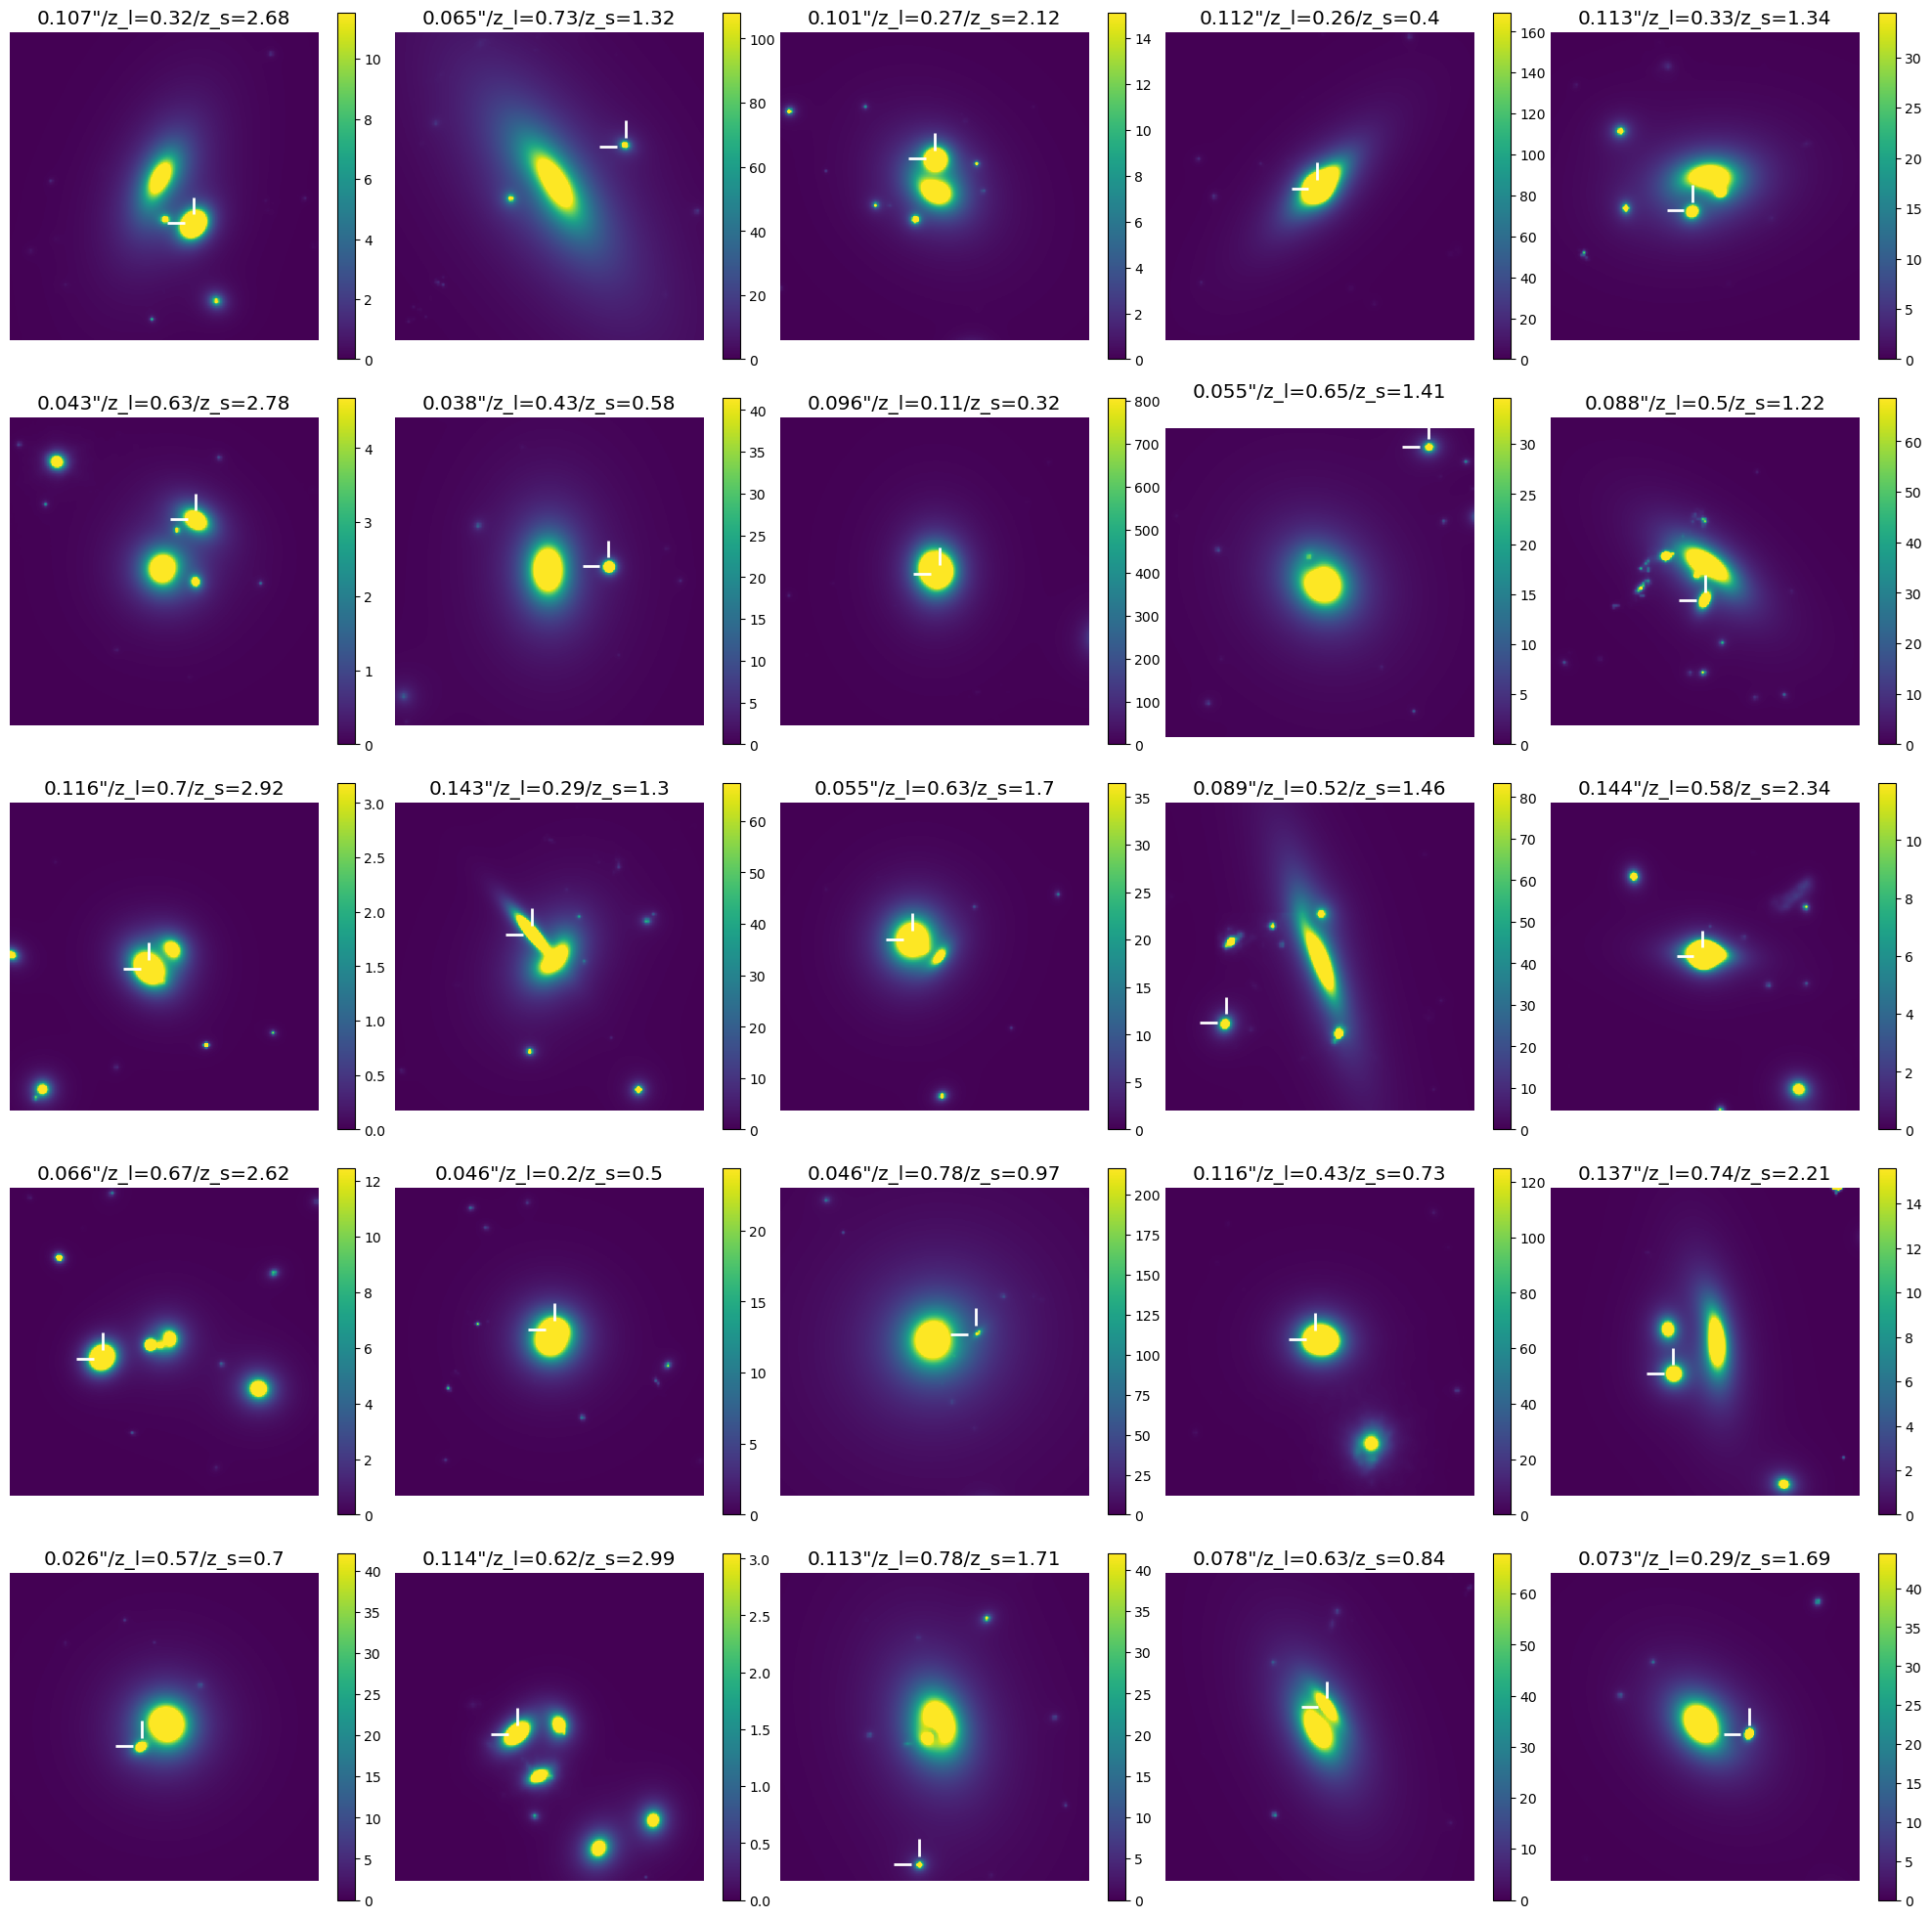

In [32]:
#5x5 test of simulation code
fig, axs = plt.subplots(5,5, dpi=100, figsize=(20,20))
background_rms=0
j = 0; np.random.seed(1)
for i in tqdm.tqdm(range(25)):
    image_real, _, theta_E, z_lens, z_source,image_source, unlensed_source, _, _ = simulate(exp_time=1200, lensed=True, sersic_source=True)    
    image_real += sim_background(exp_time=1200)
    
    im = axs[i//5,i%5].imshow(image_real, vmin=0, vmax = np.percentile(image_real,99), origin="lower")
    plt.colorbar(im,ax=axs[i//5,i%5],shrink=.9)
        
    axs[i//5,i%5].axis('off')
    axs[i//5,i%5].set_title(str(np.round(theta_E, 3))+'"/z_l='+str(np.round(z_lens,2))+"/z_s="+str(np.round(z_source,2)), fontsize="x-large")
    
    xl, yl = np.unravel_index(np.argmax(image_real-image_source),image_real.shape)
    axs[i//5,i%5].hlines(xl, yl-10.5,yl-3.5, color="white", linewidth=2)
    axs[i//5,i%5].vlines(yl, xl+3.5,xl+10.5, color="white", linewidth=2)

    i += 1
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0);

100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


Text(0, 0.5, 'Count')

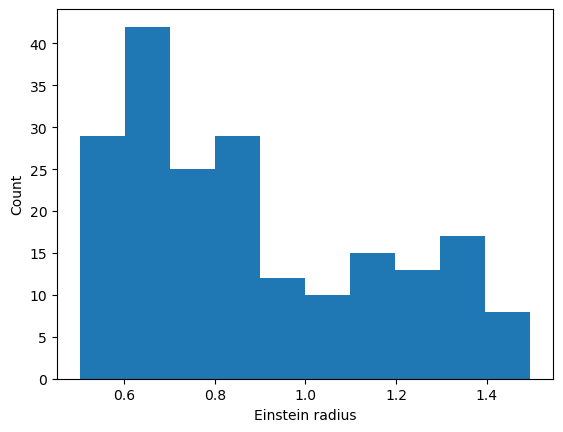

In [20]:
#Shows Einstein radius distribution
tes = np.zeros(200)
for i in tqdm.tqdm(range(200)):
    image_real, _, theta_E, z_lens, z_source,image_source, unlensed_source, mass, mStar = simulate(exp_time=1200,lensed=True, sersic_source=False)
    tes[i] = theta_E
plt.hist(tes)
plt.xlabel('Einstein radius')
plt.ylabel('Count')

In [42]:
#Generates the images along with diagnostics files
import time
pixels = 125
start = time.time()
arr = np.concatenate([np.zeros(10000), np.ones(10000)])
vsims = np.array(["vela35_"]*len(arr))
theta_Es, z_lens, z_source, image_source, unlensed_source, no_lens, mass, mStar = np.zeros(len(arr)), np.zeros(len(arr)), np.zeros(len(arr)), np.zeros((len(arr), pixels, pixels)), np.zeros((len(arr), pixels, pixels)), np.zeros((len(arr), pixels, pixels)), np.zeros(len(arr)), np.zeros(len(arr))
np.random.shuffle(arr)
background_rms=0; exp_time=1380
sersic_source=False
images = np.zeros((len(arr), pixels, pixels))
print('size:',size,", bkg:",background_rms)
for i in tqdm.tqdm(range(len(arr))):
    if arr[i] == 0:
        images[i], vsims[i], theta_Es[i], z_lens[i], z_source[i], image_source[i], unlensed_source[i], mass[i], mStar[i] = simulate(exp_time=exp_time,lensed=False)
    else:
        images[i], vsims[i], theta_Es[i], z_lens[i], z_source[i], image_source[i], unlensed_source[i], mass[i], mStar[i] = simulate(exp_time=exp_time,lensed=True, sersic_source=sersic_source)
    back_gals = sim_background(exp_time=exp_time)
    images[i] += back_gals
    no_lens[i] = image_source[i] + back_gals
    # np.save("jwst_sims/image_"+str(i), im)

size: .5-1.5 , bkg: 0


100%|██████████| 20000/20000 [2:13:01<00:00,  2.51it/s]  


In [43]:
#Saves the files to path
path = '/global/cfs/projectdirs/deepsrch/jwst_sims/sims.5-1.5_sersic'
np.save(path+"/images", images)
np.save(path+"/lensed", arr)
np.save(path+"/vsims", vsims)
np.save(path+"/theta_Es", theta_Es)
np.save(path+"/masses", mass)
np.save(path+"/mStar", mStar)
np.save(path+"/z_lens", z_lens)
np.save(path+"/z_source", z_source)
np.save(path+"/image_source", image_source)
np.save(path+"/no_lens", no_lens)
np.save(path+"/unlensed_source",unlensed_source)
time.time()-start

7992.807583808899